In [41]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import Augmentor
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


2024-03-12 11:22:59.141262: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 11:22:59.209246: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [54]:
data_dir_train = pathlib.Path("archive (1)/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("archive (1)/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
dermatofibromaval_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [9]:
# Get the class names
class_names = train_ds.class_names

print("Class Names:", class_names)

Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


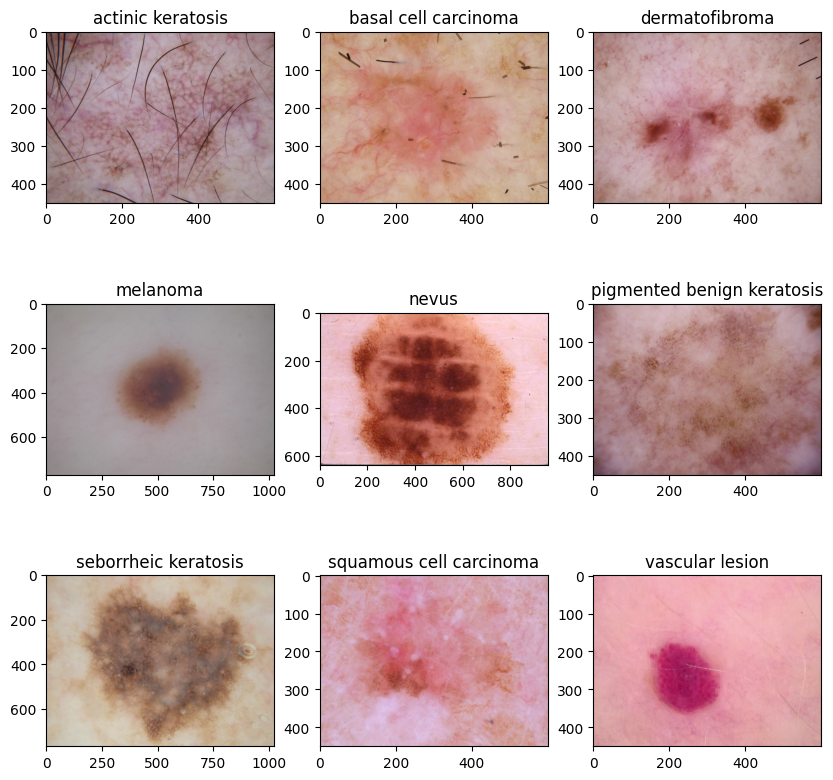

In [10]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [11]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model 1 : standard Model

In [13]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [14]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [16]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 16s 249ms/step - loss: 2.0102 - accuracy: 0.2344 - val_loss: 1.9197 - val_accuracy: 0.2998
Epoch 2/25
56/56 [==============================] - 13s 241ms/step - loss: 1.8893 - accuracy: 0.2919 - val_loss: 1.8604 - val_accuracy: 0.3579
Epoch 3/25
56/56 [==============================] - 14s 249ms/step - loss: 1.7661 - accuracy: 0.3566 - val_loss: 1.6296 - val_accuracy: 0.3937
Epoch 4/25
56/56 [==============================] - 14s 255ms/step - loss: 1.5821 - accuracy: 0.4319 - val_loss: 1.6594 - val_accuracy: 0.4228
Epoch 5/25
56/56 [==============================] - 14s 254ms/step - loss: 1.5601 - accuracy: 0.4425 - val_loss: 1.5370 - val_accuracy: 0.4653
Epoch 6/25
56/56 [==============================] - 14s 249ms/step - loss: 1.5019 - accuracy: 0.4604 - val_loss: 1.4707 - val_accuracy: 0.5213
Epoch 7/25
56/56 [==============================] - 14s 244ms/step - loss: 1.4363 - accuracy: 0.4939 - val_loss: 1.4698 - val_accuracy: 0.5101

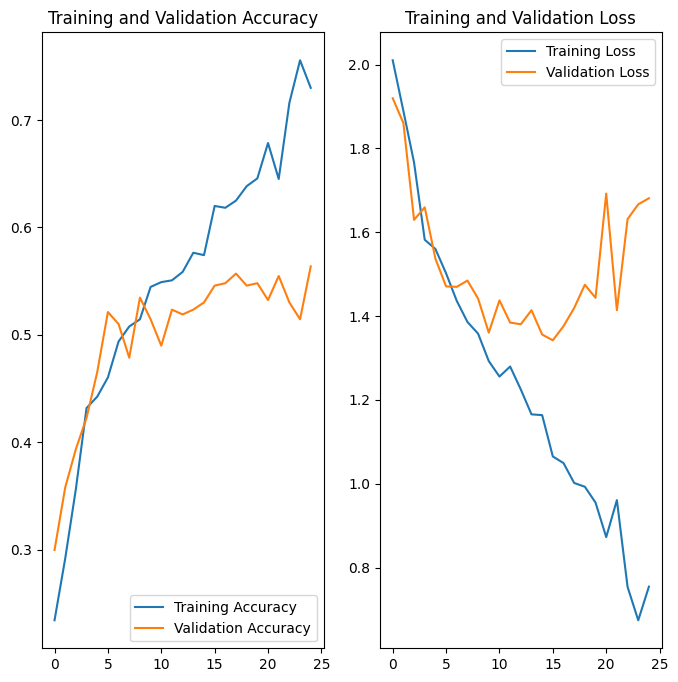

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2 : Data Augumentation with drop out layer.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


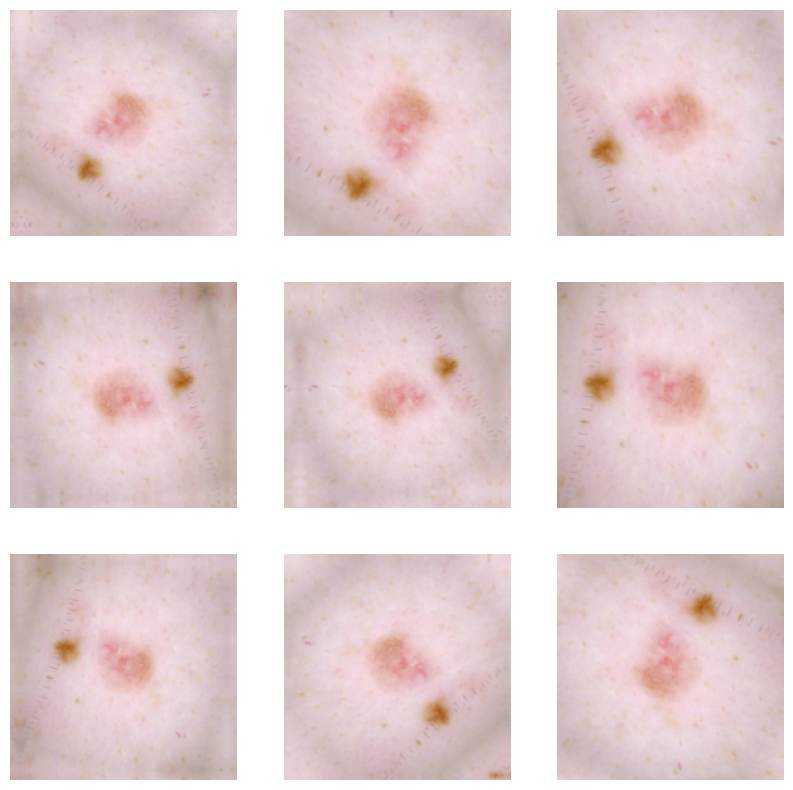

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [20]:
num_classes = 9
model = Sequential(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [21]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 15s 261ms/step - loss: 2.0505 - accuracy: 0.2154 - val_loss: 1.9071 - val_accuracy: 0.2975
Epoch 2/25
56/56 [==============================] - 15s 264ms/step - loss: 1.8430 - accuracy: 0.3315 - val_loss: 1.8076 - val_accuracy: 0.3400
Epoch 3/25
56/56 [==============================] - 15s 260ms/step - loss: 1.7015 - accuracy: 0.3583 - val_loss: 1.6244 - val_accuracy: 0.4049
Epoch 4/25
56/56 [==============================] - 14s 258ms/step - loss: 1.5917 - accuracy: 0.4252 - val_loss: 1.5018 - val_accuracy: 0.4899
Epoch 5/25
56/56 [==============================] - 14s 258ms/step - loss: 1.5490 - accuracy: 0.4626 - val_loss: 1.5591 - val_accuracy: 0.4541
Epoch 6/25
56/56 [==============================] - 15s 265ms/step - loss: 1.4832 - accuracy: 0.4660 - val_loss: 1.4988 - val_accuracy: 0.5123
Epoch 7/25
56/56 [==============================] - 15s 264ms/step - loss: 1.4375 - accuracy: 0.4983 - val_loss: 1.4489 - val_accuracy: 0.4989

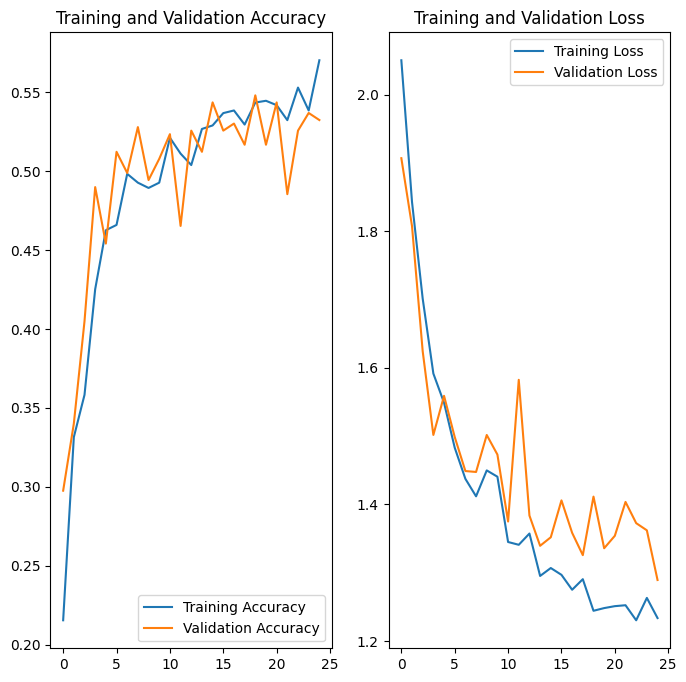

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Analysing the class imbalance of the data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

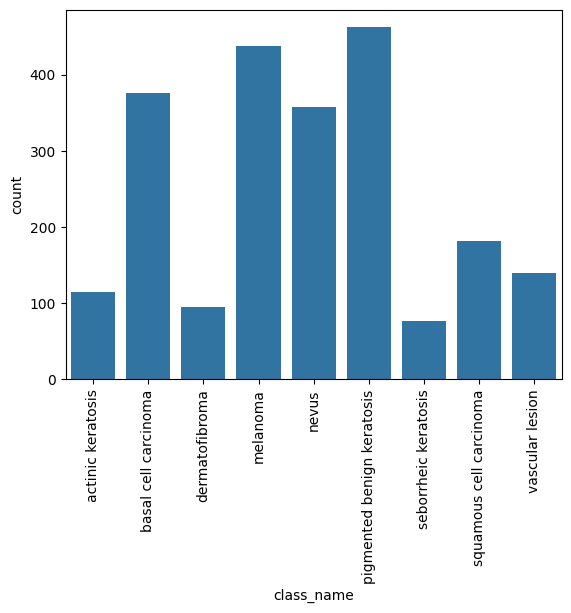

In [24]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

## Findings
Data is hevily imbalance and hence due to that results and predictions will be baised.

## SMOTE : Class balance

In [29]:
import Augmentor
import SMOTE as st

In [30]:
path_to_training_dataset = "archive (1)/Skin cancer ISIC The International 
Skin Imaging Collaboration/Train"
output_base_directory = '/home/admin1/data/'

for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    output_directory = os.path.join(output_base_directory, i, 'output')
    
    p = Augmentor.Pipeline(class_path, output_directory=output_directory)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to /home/admin1/data/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9CAABE3950>: 100%


Initialised with 376 image(s) found.
Output directory set to /home/admin1/data/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9CAAC9E9D0>: 100%


Initialised with 95 image(s) found.
Output directory set to /home/admin1/data/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 438 image(s) found.
Output directory set to /home/admin1/data/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0


Initialised with 357 image(s) found.
Output directory set to /home/admin1/data/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F9CA8D59510>: 100%


Initialised with 462 image(s) found.
Output directory set to /home/admin1/data/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9CAAC9E810>: 100%


Initialised with 77 image(s) found.
Output directory set to /home/admin1/data/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9CAACCF690>: 100


Initialised with 181 image(s) found.
Output directory set to /home/admin1/data/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DE00ED510>: 100%


Initialised with 139 image(s) found.
Output directory set to /home/admin1/data/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E9AF134D0>: 100%


In [31]:
# path_to_training_dataset = "archive (1)/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/home/sumeet/Model/data/'+i+'/output/')
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(1000) 

In [32]:
output_dir = pathlib.Path('/home/admin1/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

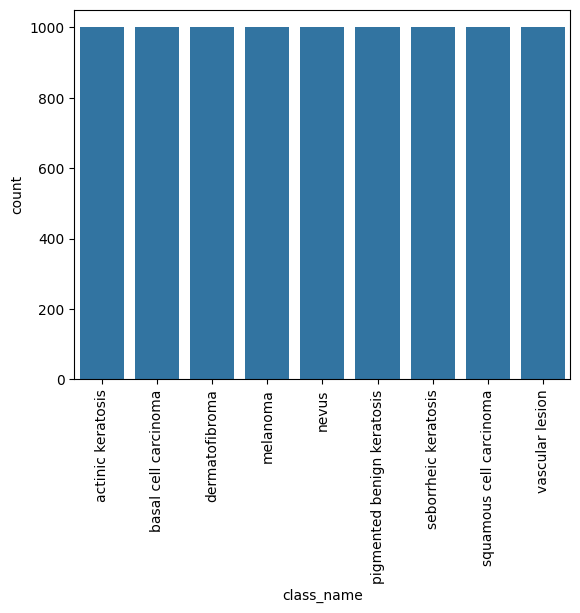

In [33]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

## Model 3 : Model with Class balance data.

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [36]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [37]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [38]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [39]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
225/225 [==============================] - 57s 250ms/step - loss: 1.9299 - accuracy: 0.2226 - val_loss: 1.6067 - val_accuracy: 0.3556
Epoch 2/25
225/225 [==============================] - 56s 250ms/step - loss: 1.5415 - accuracy: 0.3988 - val_loss: 1.4124 - val_accuracy: 0.4394
Epoch 3/25
225/225 [==============================] - 58s 258ms/step - loss: 1.3708 - accuracy: 0.4735 - val_loss: 1.2683 - val_accuracy: 0.5056
Epoch 4/25
225/225 [==============================] - 56s 248ms/step - loss: 1.2237 - accuracy: 0.5294 - val_loss: 1.2239 - val_accuracy: 0.5400
Epoch 5/25
225/225 [==============================] - 56s 249ms/step - loss: 1.1065 - accuracy: 0.5793 - val_loss: 1.0643 - val_accuracy: 0.5828
Epoch 6/25
225/225 [==============================] - 56s 248ms/step - loss: 0.9691 - accuracy: 0.6356 - val_loss: 0.9188 - val_accuracy: 0.6572
Epoch 7/25
225/225 [==============================] - 56s 248ms/step - loss: 0.8048 - accuracy: 0.7006 - val_loss: 0.7279 - val_ac

In [42]:
model.save('model.h5')

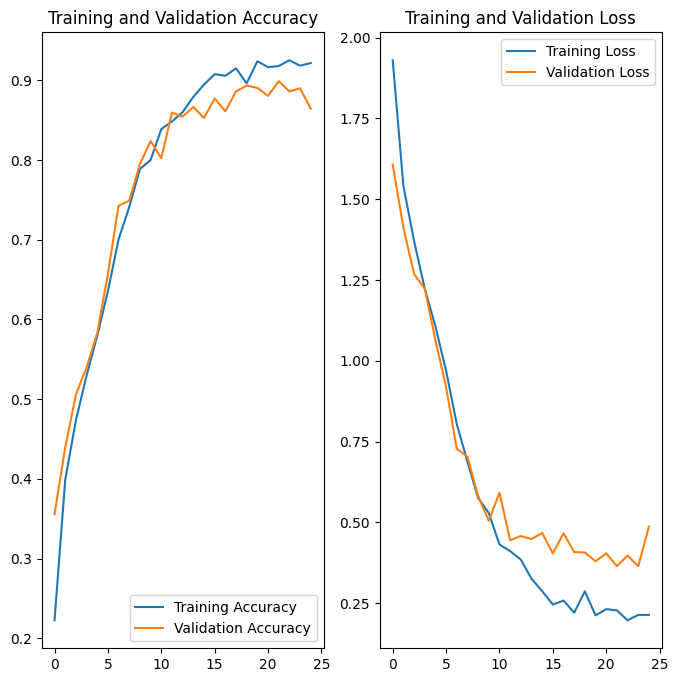

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

ResNet50

In [45]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, 
                      input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
history_resnet = model.fit(train_ds, validation_data=val_ds, 
                           epochs=epochs)

model.save('ResNet50.h5')

Epoch 1/25
225/225 [==============================] - 158s 694ms/step - loss: 3.8751 - accuracy: 0.6674 - val_loss: 0.5543 - val_accuracy: 0.8156
Epoch 2/25
225/225 [==============================] - 154s 686ms/step - loss: 0.3060 - accuracy: 0.9060 - val_loss: 0.4073 - val_accuracy: 0.8828
Epoch 3/25
225/225 [==============================] - 154s 686ms/step - loss: 0.1685 - accuracy: 0.9454 - val_loss: 0.3506 - val_accuracy: 0.8922
Epoch 4/25
225/225 [==============================] - 154s 686ms/step - loss: 0.1425 - accuracy: 0.9524 - val_loss: 0.3753 - val_accuracy: 0.8817
Epoch 5/25
225/225 [==============================] - 155s 687ms/step - loss: 0.1256 - accuracy: 0.9553 - val_loss: 0.3712 - val_accuracy: 0.8739
Epoch 6/25
225/225 [==============================] - 155s 687ms/step - loss: 0.1894 - accuracy: 0.9356 - val_loss: 0.6488 - val_accuracy: 0.8261
Epoch 7/25
225/225 [==============================] - 155s 687ms/step - loss: 0.2416 - accuracy: 0.9260 - val_loss: 0.4667 -

DenseNet169

In [43]:
from tensorflow.keras.applications import DenseNet169

# Load the pre-trained DenseNet169 model without the top (classification) layer
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add your classification layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_densenet = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


51877672/51877672 [==============================] - 28s 1us/step
Epoch 1/25
225/225 [==============================] - 129s 557ms/step - loss: 19.7602 - accuracy: 0.4692 - val_loss: 1.2174 - val_accuracy: 0.5606
Epoch 2/25
225/225 [==============================] - 123s 547ms/step - loss: 0.9543 - accuracy: 0.6715 - val_loss: 1.0831 - val_accuracy: 0.6494
Epoch 3/25
225/225 [==============================] - 123s 547ms/step - loss: 0.7149 - accuracy: 0.7443 - val_loss: 0.7334 - val_accuracy: 0.7506
Epoch 4/25
225/225 [==============================] - 123s 547ms/step - loss: 0.5864 - accuracy: 0.7865 - val_loss: 0.7071 - val_accuracy: 0.7306
Epoch 5/25
225/225 [==============================] - 123s 547ms/step - loss: 0.4472 - accuracy: 0.8339 - val_loss: 0.5577 - val_accuracy: 0.7894
Epoch 6/25
225/225 [==============================] - 124s 551ms/step - loss: 0.4077 - accuracy: 0.8518 - val_loss: 0.4209 - val_accuracy: 0.8494
Epoch 7/25
225/225 [==============================] - 124

In [44]:
model.save('DenseNet.h5')